# Machine Learning
---
### Lecture 7: Ensembles

In [44]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pylab as plt

import matplotlib
nice_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
#     "font.size": 30,
    "lines.linewidth":3,
    "axes.titlesize":30,
    "axes.labelsize":24,
    "xtick.labelsize":14,
    "ytick.labelsize":14,
}
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams.update(nice_fonts)
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)

## Learning Outcomes

- understand bias-variace trade-off in machine learning 
- get familiar with ensembling methods, their differences, similarities and motivation
- understand random forest model

# Intro: Motivation
--- 

In [45]:
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_circles

  
    
X_1, y_1 = make_circles(noise=0.2, factor=0.5, random_state=1)
X_2, y_2 = make_circles(noise=0.2, factor=0.5, random_state=2)
X_toy = np.concatenate([X_1, X_2 + 2.])
y_toy = np.concatenate([y_1, 1-y_2])

def select_subsample(X, y):
    idx_part = np.random.choice(len(X), replace=False, size=int(0.9 * len(X)))
    X_part, y_part = X[idx_part, :], y[idx_part]
    return X_part, y_part

last time we discussed decision trees and menioned that they have large variance. 

let's try to figure out, why that happens and what can we do to that

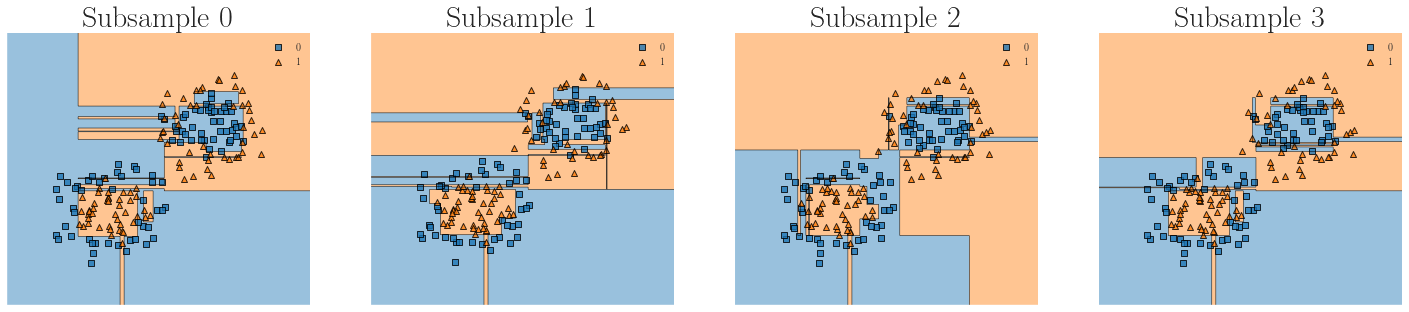

In [46]:
fig, ax = plt.subplots(ncols=4, figsize=(25, 5))
for i in range(4):
    np.random.seed(i)
    X_part, y_part = select_subsample(X_toy, y_toy)
    dt = DecisionTreeClassifier(random_state=13)
    dt.fit(X_part, y_part)
    ax[i].set_title('Subsample {}'.format(i))
    ax[i].axis('off')
    plot_decision_regions(X_part, y_part, dt, ax=ax[i])

# Bias-Variance Trade-off
--- 


#### Setup: regression with quadratic loss

* We would like to approximate $f$ - function which connects feature vector $x$ and real-valued target $y$:
\begin{align}
y &= f(x) + \varepsilon\\
x &\sim p(x) \\
\varepsilon &\sim p(\varepsilon), \quad \mathbb{E}(\varepsilon) = 0
\end{align}

* Dataset
$$
\mathbb{X} = \{x_n, y_n \}_{n=1}^N - \text{i.i.d. samples from } p(x, y)\\
$$

* We fit model $a$ using a given dataset $\mathbb{X}$:

$$
a^* = \arg\min_a \frac{1}{N} \sum_n (y_n - a(x_n))^2
$$

- If we observe a slightly different dataset, the resulting model will be different as well:

$$a^*(x) \Rightarrow a^*_{\mathbb{X}}(x)$$


#### How to measure error of $a$ independent of $\mathbb{X}$?


Let's try to measure how good our algorithm a is fitting function f?

Can we use out cost function - loss averaged over the 

we already know what overfitting is: if an algorithm has 0 error on training dataset it does not mean that it is actually good. 

On practice we used validation or cross-validation. But again, how do we know that

$$
\mathcal{R}(a) = \mathbb{E}_{\mathbb{X}} \mathbb{E}_{p(x, y)} \left[ (y - a_{\mathbb{X}}(x))^2 \right]
$$


* **Trick 1. Inner expectation:** $ \pm f(x)$ and open the brackets:
$$
\mathbb{E}_{p(x, y)} \left[ (y - a_{\mathbb{X}}(x))^2 \right] =  \mathbb{E}_{p(x, y)} \left[ (y - f(x) + f(x) - a_{\mathbb{X}}(x))^2 \right] = \\
 \mathbb{E}_{p(x, y)} \left[(y - f(x))^2\right] + 2 \mathbb{E}_{p(x, y)} \left[ (y - f(x)) (f(x) - a_{\mathbb{X}}(x))\right] +  \mathbb{E}_{p(x, y)} \left[(f(x) - a_{\mathbb{X}}(x))^2\right] =\\
 \mathbb{V}(\varepsilon) + 0 +  \mathbb{E}_{p(x, y)} \left[(f(x) - a_{\mathbb{X}}(x))^2\right]
$$

* Plug back:
$$
\mathcal{R}(a) = \mathbb{E}_{\mathbb{X}}\left[ \mathbb{V}(\varepsilon)  +  \mathbb{E}_{p(x, y)} \left[(f(x) - a_{\mathbb{X}}(x))^2\right]\right] = \mathbb{V}(\varepsilon)  + \mathbb{E}_{\mathbb{X}} \mathbb{E}_{p(x, y)} \left[(f(x) - a_{\mathbb{X}}(x))^2\right]
$$

#### How to measure error of $a$ independent of $\mathbb{X}$?
$$
\mathcal{R}(a) = \mathbb{E}_{\mathbb{X}} \mathbb{E}_{p(x, y)} \left[ (y - a_{\mathbb{X}}(x))^2 \right]
$$
* **Trick 1. Inner expectation:** $ \pm f(x)$ and open the brackets:

$$
\mathcal{R}(a) = \mathbb{E}_{\mathbb{X}}\left[ \mathbb{V}(\varepsilon)  +  \mathbb{E}_{p(x, y)} \left[(f(x) - a_{\mathbb{X}}(x))^2\right]\right] = \mathbb{V}(\varepsilon)  + \mathbb{E}_{\mathbb{X}} \mathbb{E}_{p(x, y)} \left[(f(x) - a_{\mathbb{X}}(x))^2\right]
$$

* **Trick 2.  Second term:** swap expectations, $\pm \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x)$ and open the brackets:

$$
\mathbb{E}_{\mathbb{X}}\left[(f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x) + \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x) - a_{\mathbb{X}}(x))^2\right] =  
  \mathbb{E}_{\mathbb{X}}\left[ (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] +  \mathbb{E}_{\mathbb{X}}\left[ ( \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x) - a_{\mathbb{X}}(x))^2 \right] = \\
 (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 +  \mathbb{V}( a_{\mathbb{X}}(x)) 
$$

* All together:

$$
\mathcal{R}(a) = \mathbb{V}(\varepsilon)  +  \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] +  \mathbb{E}_{p(x, y)} \left[  \mathbb{V}( a_{\mathbb{X}}(x))  \right]
$$

Expexted error = Irreducible noise + Bias^2 + Variance

The same can be derived for classification: [link](https://www.jmlr.org/papers/volume5/valentini04a/valentini04a.pdf)

In [48]:
from sklearn.linear_model import LinearRegression

# Generate data
fun = lambda x: 0.5*np.sin(x)
N = 20
np.random.seed(6)
x = np.arange(-4, 4, 8./N)
y = fun(x) + np.random.randn(N)*0.2
x_grid = np.arange(min(x), max(x), 0.01)
y_grid = fun(x_grid) + np.random.randn(x_grid.shape[0])*0.2


# plot
def plot_real_fun(ax):
    ax.plot(x_grid, fun(x_grid), label='True function', c='coral')
    ax.scatter(x, y, label = 'Observed Data', c='royalblue')
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('y', fontsize=16)
#     ax.grid()

# fit and plot polynomial lr
def make_pow(x, p = 4):
    X = [x**i for i in range(1, p+1)]
    return(np.stack(X, axis=1))


def plot_poly_reg(x, y, P, c='seagreen', name='Model', linestyle='-', ax=None):
    lr = LinearRegression().fit(make_pow(x, P), y)
    ax.plot(x_grid, lr.predict(make_pow(x_grid, P)), 
            label=name, c=c,linestyle=linestyle)
    return lr

def estimate_bias_variance(x, y, mod, s=40, max_iter=1000):
    x_grid = np.arange(-4, 4, 0.05)
    predictions = []
    for _ in range(max_iter):
        # sample
        ids = np.random.choice(x.shape[0], size=s, replace=False)
        x_new = x[ids]
        y_new = y[ids]

        # fit model
        m = mod.fit(x_new, y_new)

        # predict
        y_pred = mod.predict(x)
        predictions.append(y_pred) 
        
    variance = (np.stack(predictions).std(0)**2).mean()
    bias = np.mean((y - np.stack(predictions).mean(0))**2)
    return bias, variance

$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}( a_{\mathbb{X}}(x))  \right]
$$

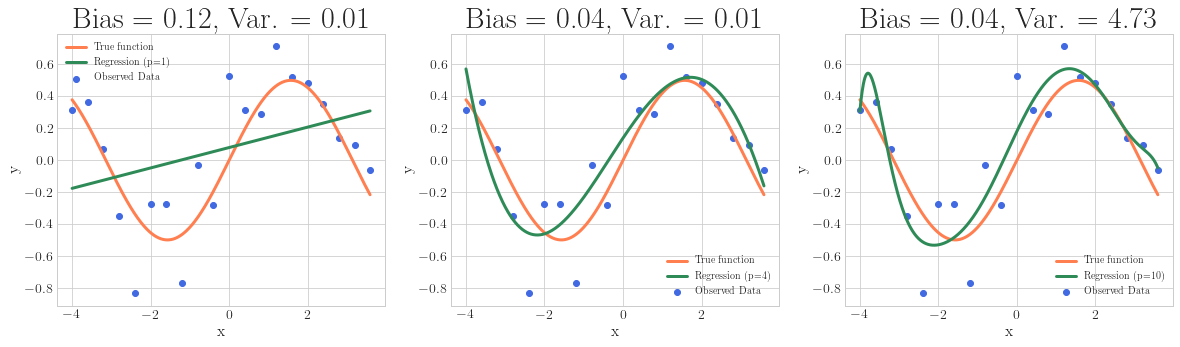

In [49]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5)) 

for i, p in enumerate([1, 4, 10]):
    plot_real_fun(ax[i])
    plot_poly_reg(x, y, p, name='Regression (p={})'.format(p), ax=ax[i])
    
    b, v = estimate_bias_variance(make_pow(x_grid, p), y_grid, LinearRegression())
    ax[i].set_title('Bias = {:.2f}, Var. = {:.2f}'.format(b, v))
    ax[i].legend()

In [50]:
def plot_variance(x, y, mod, ax):
# def estimate_bias_variance(x, y, mod):
    x_grid = np.arange(-4, 4, 0.05)
    predictions = []
    for _ in range(1000):
        # sample
        ids = np.random.choice(x.shape[0], size=40, replace=False)
        x_new = x[ids]
        y_new = y[ids]

        # fit model
        m = mod.fit(x_new, y_new)
#         lr = LinearRegression().fit(make_pow(x_new, P), y_new)

        # predict
#         y_pred = lr.predict(make_pow(x_grid, P))
        y_pred = mod.predict(x)
        predictions.append(y_pred) 
        ax.plot(x[:, 0], y_pred, alpha=0.01, c='g',linewidth=0.5)
        ax.set_ylim(-1, 1)

    predictions = np.stack(predictions)
    ax.plot(x[:, 0], np.mean(predictions, axis=0), alpha=0.8, c='g')    

$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}( a_{\mathbb{X}}(x))  \right]
$$

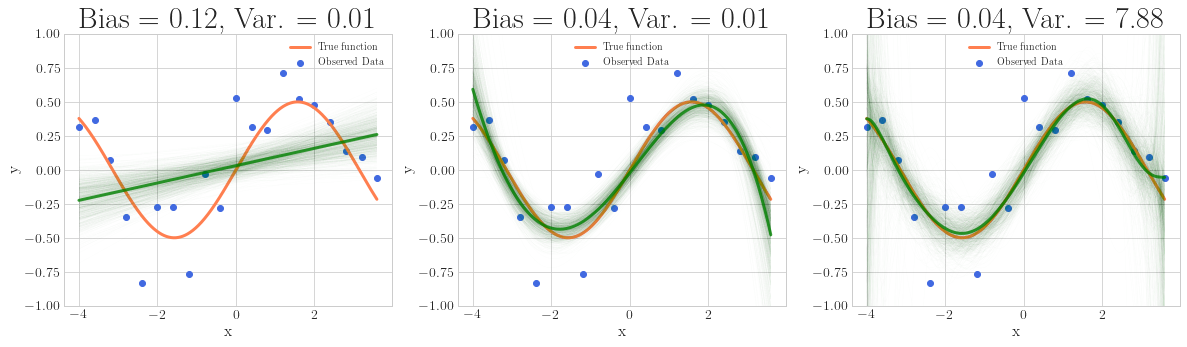

In [51]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5)) 

for i, p in enumerate([1, 4, 10]):
    plot_real_fun(ax[i])
    plot_variance(make_pow(x_grid, p), y_grid, LinearRegression(), ax=ax[i])
    b, v = estimate_bias_variance(make_pow(x_grid, p), y_grid, LinearRegression())
    ax[i].set_title('Bias = {:.2f}, Var. = {:.2f}'.format(b, v))
    ax[i].legend()

In [52]:
from sklearn.linear_model import Lasso, Ridge
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.load_diabetes()
X_db, y_db = data['data'], data['target']
lbd_vals = np.array([0, 0.1, 0.5, 1, 2, 4])[::-1]
bv_res = np.stack([np.array(estimate_bias_variance(X_db, y_db, Lasso(alpha=lbd), s=int(X_db.shape[0]*0.1), max_iter=1000)) for lbd in lbd_vals])

In [53]:
def get_mse(X_tr, X_te, y_tr, y_te, model):
    model.fit(X_tr, y_tr)
    y_tr_p = model.predict(X_tr)
    y_te_p = model.predict(X_te)
    
    mse_tr = np.mean((y_tr - y_tr_p)**2)
    mse_te = np.mean((y_te - y_te_p)**2)
    return mse_tr, mse_te
X_tr, X_te, y_tr, y_te = train_test_split(X_db, y_db, random_state=666)
fit_res = np.stack([np.array(get_mse(X_tr, X_te, y_tr, y_te, Lasso(alpha=lbd))) for lbd in lbd_vals])

### Example: Predict diabetes progression
* 10 features, Lasso model

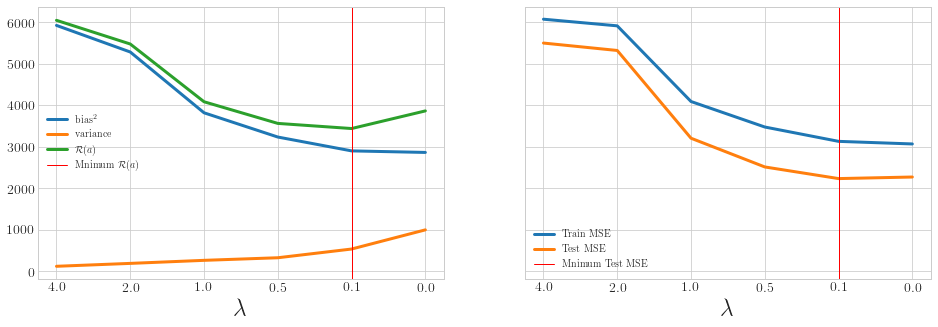

In [54]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 5), sharey=True)

ax[0].plot(bv_res[:, 0], label=r'bias$^2$')
ax[0].plot(bv_res[:, 1], label='variance')
ax[0].plot(bv_res.sum(1), label=r'$\mathcal{R}(a)$')
ax[0].axvline(x = np.argmin(bv_res.sum(1)), linewidth=1, c='r', label=r'Mnimum $\mathcal{R}(a)$')
ax[0].set_xticks(range(lbd_vals.shape[0]))
ax[0].set_xticklabels(labels=lbd_vals)
ax[0].set_xlabel(r'$\lambda$')
ax[0].legend();

ax[1].plot(fit_res[:,0], label='Train MSE')
ax[1].plot(fit_res[:,1], label='Test MSE')
ax[1].axvline(x = np.argmin(fit_res[:,1]), linewidth=1, c='r', label=r'Mnimum Test MSE')
ax[1].set_xticks(range(lbd_vals.shape[0]))
ax[1].set_xticklabels(labels=lbd_vals)
ax[1].set_xlabel(r'$\lambda$')
ax[1].legend();

# Ensembles
--- 
- Bagging
- Boosting
- Stacking
- Blending
- ...


We observe that complex models have low bias -> on average they are pretty good. But we cannot use that because of large variance

**idea** what if we use average prediction? 

The whole range of ensembling techniques is based in this observation. 

### Composition of models

* Let's train $M$ base models:

$$
b_1(x), \dots, b_M(x)
$$

* And create a composition 

$$a_M(x) = f(b_1(x), \dots, b_M(x))$$

* E.g. by averaging their predictions:

$$a_M(x) = \frac{1}{M}\sum_{m=1}^M b_m(x)$$

### Variety of Composition Algorithms

* Do all $b_m$ come from the same familty?
     - Yes $\Rightarrow$ Bagging, Random subspaces, Boosting
     - No $\Rightarrow$ Stacking, Blending, Voting
* Do we train $b_m$ independently?
    - Yes $\Rightarrow$ Bagging, Random subspaces
    - No $\Rightarrow$ Boosting

### Base models from the same family

* $M$ base models: $b_1(x), \dots, b_M(x)$

* How to build $M$ different models using only $1$ training dataset?


Two options:
- Train on different subsamples
    * Bagging
    * Random subsamples
- Train successively to correct errors of the previous algorim     
    * Boosting

### Bagging

**B**ootstrap **agg**regat**ing**

- Use Bootstrap to create a subsamples
- Train each base model on a new subsample
- Aggregate predictions:
    * Averaging for regression: $a_M(x) = \frac{1}{M}\sum_{m=1}^M b_m(x)$
    
    * Magority vote for classification: $a_M(x) = \arg\max_{y \in \mathbb{Y}}\sum_{m=1}^M \left[b_m(x) = y\right]$

### Bootstrap

* Create subsamples with replacement

E.g. given dataet with $N$ observations we independetly select $N$ observations (withe replacement):

$$
\{x_1, x_2, x_3, x_4\} \rightarrow \{x_2, x_1, x_2, x_4\}
$$

* A new subsample will have $\approx 63.2\%$  unique observations

### Random Subspaces

* Select a random subset of features
* Train each base model on a new set of features
* May work poorly if some feature is critical for a reasonable model

### Two sources of randomness 

<table><tr>
<td> <img src="img/7_1.png" alt="Drawing" style="width: 800px;"/> </td>
</tr></table>

### Bias and Variance
* $M$ base models: $b_1(x), \dots, b_M(x)$
  - independent
  - from the same family
    
* They have the same bias and variance. Denote:
$$
\mathbb{E}_{\mathbb{X}}b_i(x) = \mu(x)\quad \forall i = 1,\dots, M \\
\mathbb{V}_{\mathbb{X}}b_i(x) = \nu(x)\quad \forall i = 1,\dots, M \\
$$

### Bias and Variance

* Bias$^2$

$$
\mathbb{E}_{p(x, y)}\left[f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x) \right]^2 =  \mathbb{E}_{p(x, y)}\left[f(x) - \mathbb{E}_{\mathbb{X}}\frac{1}{M}\sum_{m=1}^M b_m(x) \right]^2 = \mathbb{E}_{p(x, y)}\left[f(x) - \mu(x) \right]^2 
$$

* Variance

$$
\mathbb{E}_{p(x, y)} \mathbb{V} (a_{\mathbb{X}}(x) ) = \frac{1}{M} \mathbb{E}_{p(x, y)} \nu(x) + \frac{1}{M^2}\sum_{i\neq j} \mathbb{E}_{p(x, y)} \mathbb{C}\text{ov}(b_i(x), b_j(x))
$$

* If base models are **independent** we get variance, which is $M$ times smaller with the same bias

* The more correlated models are, the smaller is effect of the ensemble

### Base Models from different families

* Voting Regressor / Classifier
    - Train $M$ different models (e.g. Linear Regression, kNN and Decision Tree)
    - Combine prediction through averagining or majority vote

* Stacking (Stacked Generalization)
    - Train $M$ different models (e.g. Linear Regression, kNN and Decision Tree)
    - $M$ new features --- predictions of the base classifiers
    - Train **final estimator** on the new features
    
* Blending
    - Special case of staking 

# Random Forest
--- 

Bagging + Random Subsets + Decision Trees

* Decision Trees have low bias
* Bagging and Random Subsamples reduce variance

### RF algorithm

* For $m = 1, \dots, M$:
    * Sample $\widehat{X}$ via bootstrap
    * Train decision tree $b_m(x)$ on $\widehat{X}$:
        - Usually deep trees are used
        - For **each** split: select best split among random subset of features


In [172]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from scipy.stats.stats import pearsonr


# Generate a binary classification dataset.
X, y = make_regression(n_samples=1000, n_features=20, random_state=1, n_informative=5)
X_train, X_test, y_train, y_test = train_test_split(X, y)

def get_correlations(clf, X):
    # get all pairs of trees:
    a = np.array(range(len(clf.estimators_)))
    mesh = np.array(np.meshgrid(a, a))
    combinations = mesh.T.reshape(-1, 2)
    
    corr = []
    for tr_1, tr_2 in combinations:
        ytest_0 = clf.estimators_[tr_1].predict(X) 
        ytest_1 = clf.estimators_[tr_2].predict(X) 
        corr.append(pearsonr(ytest_0, ytest_1)[0])
    return corr

correlations = []
mse = []
ms = range(1, X.shape[1]+1, 3)
for m in ms:
    clf = RandomForestRegressor(n_estimators=40, max_features=m, bootstrap=False)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    correlations.append(get_correlations(clf, X_test))
    mse.append(np.mean((y_pred - y_test)**2))

### Without bootstrap

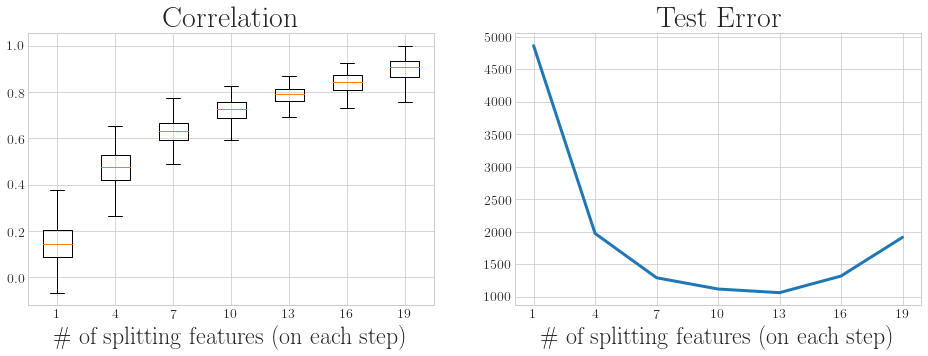

In [173]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
ax[0].set_title('Correlation')
ax[0].boxplot(correlations, sym='')
ax[0].set_xticklabels(labels=ms)
ax[0].set_xlabel('\# of splitting features (on each step)')

ax[1].set_title('Test Error')
ax[1].plot(mse);
ax[1].set_xticks(range(len(mse)))
ax[1].set_xlabel('\# of splitting features (on each step)')
ax[1].set_xticklabels(labels=ms);

### With bootstrap

In [174]:
correlations = []
mse = []
ms = range(1, X.shape[1]+1, 3)
for m in ms:
    clf = RandomForestRegressor(n_estimators=40, max_features=m, bootstrap=True)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    correlations.append(get_correlations(clf, X_test))
    mse.append(np.mean((y_pred - y_test)**2))

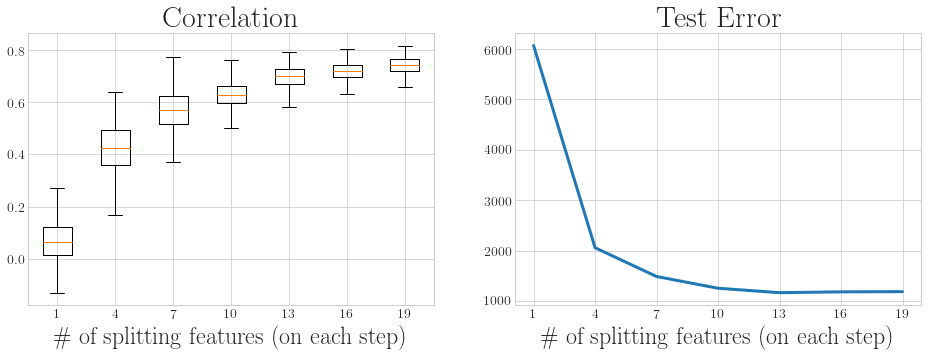

In [175]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
ax[0].set_title('Correlation')
ax[0].boxplot(correlations, sym='')
ax[0].set_xticklabels(labels=ms)
ax[0].set_xlabel('\# of splitting features (on each step)')

ax[1].set_title('Test Error')
ax[1].plot(mse);
ax[1].set_xticks(range(len(mse)))
ax[1].set_xlabel('\# of splitting features (on each step)')
ax[1].set_xticklabels(labels=ms);

### How many trees should be there?

In [176]:
mse_test = []
ns = range(4, 100, 2)
ms = [None, 'sqrt', 'log2']
for m in ms:
    mse_test.append([])
    for n in ns:
        clf = RandomForestRegressor(n_estimators=n, max_features=m)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        mse_test[-1].append(np.mean((y_pred - y_test)**2))

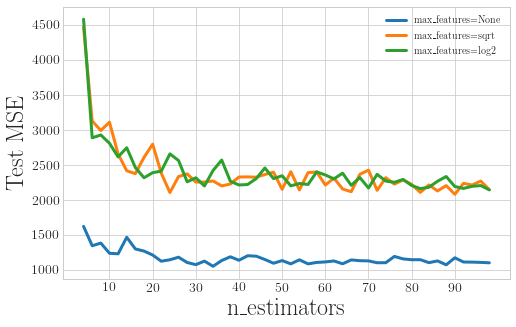

In [177]:
for i in range(3):
    plt.plot(mse_test[i], label='max\_features='+str(ms[i]))
plt.xticks(range(len(ns))[3::5], ns[3::5])
plt.xlabel('n\_estimators')
plt.ylabel('Test MSE')
plt.legend();

## Learning Outcomes

- understand bias-variace trade-off in machine learning 
- get familiar with ensembling methods, their differences, similarities and motivation
- understand random forest model
